# Linear regression

In [1]:
import numpy as np
import import_ipynb
import metrics
import matplotlib.pyplot as plt
import random

importing Jupyter notebook from metrics.ipynb


In [2]:
# model
class MyLineReg():
    def __init__(self, n_iter=100, learning_rate=0.1, weights=None, metric=None):
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.weights = weights
        self.metric = metric
        self.best_score = None
        
        
    def __str__(self):
        params = ", ".join(f"{key}={value}" for key, value in self.__dict__.items())
        return f"{__class__.__name__} class: {params}"
    
    
    def MSE(self, y_pred, y):
        return np.sum((y_pred - y)**2 / len(y))
    
    
    def predict(self, X):
        X = np.insert(X, 0, np.ones(len(X)), axis=1)
        return X @ self.weights
    
    
    def printLog(self, iter, y_pred, y):
        log = f"iter: {iter} \tloss: {round(self.MSE(y_pred, y), 3)}"
        if self.metric:
            log += f" \t{self.metric}: {round(self.get_best_score(), 3)}"
        print(log)
        
    
    def fit(self, x, y, verbose=False):
        X = np.insert(x, 0, np.ones(len(x)), axis=1)
        self.weights = np.ones(X.shape[1])
        
        for iter in range(self.n_iter):
            y_pred = self.predict(x)
            grad = 2*(y_pred - y) @ X / len(X)
            self.weights -= self.learning_rate * grad
            y_pred = self.predict(x)
            if self.metric:
                self.best_score = metrics.calcMetric(y_pred, y, self.metric)
            
            if verbose and iter % verbose == 0:
                self.printLog(iter, y_pred, y)
            
            
    def get_coef(self):
        return self.weights[1::]
    

    def get_best_score(self):
        return self.best_score

In [178]:
# data generation
k = random.uniform(-10, 10)
b = random.uniform(-10, 10)


def linear_func(x):
    return k * x + b


dataset_size = 200
x = np.random.rand(dataset_size) * 10
y = linear_func(x) + np.random.randn(dataset_size) * k

train_size = 0.5
n = int(train_size * len(x))
x_train, x_test, y_train, y_test = x[:n], x[n::], y[:n], y[n::]

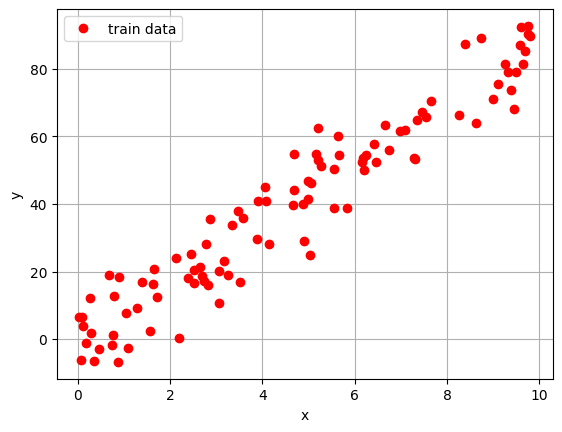

In [179]:
# draw train data
def drawDataset(x, y, name, colour='r'):
    plt.plot(x, y, colour + 'o', label=name)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)


drawDataset(x_train, y_train, "train data")
plt.show()

In [180]:
# train model
X = np.reshape(x_train, (len(x_train), 1))
myLineReg = MyLineReg(1000, 0.01, metric='r2')
myLineReg.fit(X, y_train, 100)

iter: 0 	loss: 303.717 	r2: 0.603
iter: 100 	loss: 60.414 	r2: 0.921
iter: 200 	loss: 59.687 	r2: 0.922
iter: 300 	loss: 59.458 	r2: 0.922
iter: 400 	loss: 59.385 	r2: 0.922
iter: 500 	loss: 59.362 	r2: 0.922
iter: 600 	loss: 59.355 	r2: 0.922
iter: 700 	loss: 59.353 	r2: 0.922
iter: 800 	loss: 59.352 	r2: 0.922
iter: 900 	loss: 59.352 	r2: 0.922


In [181]:
# display weights
weights = myLineReg.weights
weights

array([-1.26628797,  8.85384293])

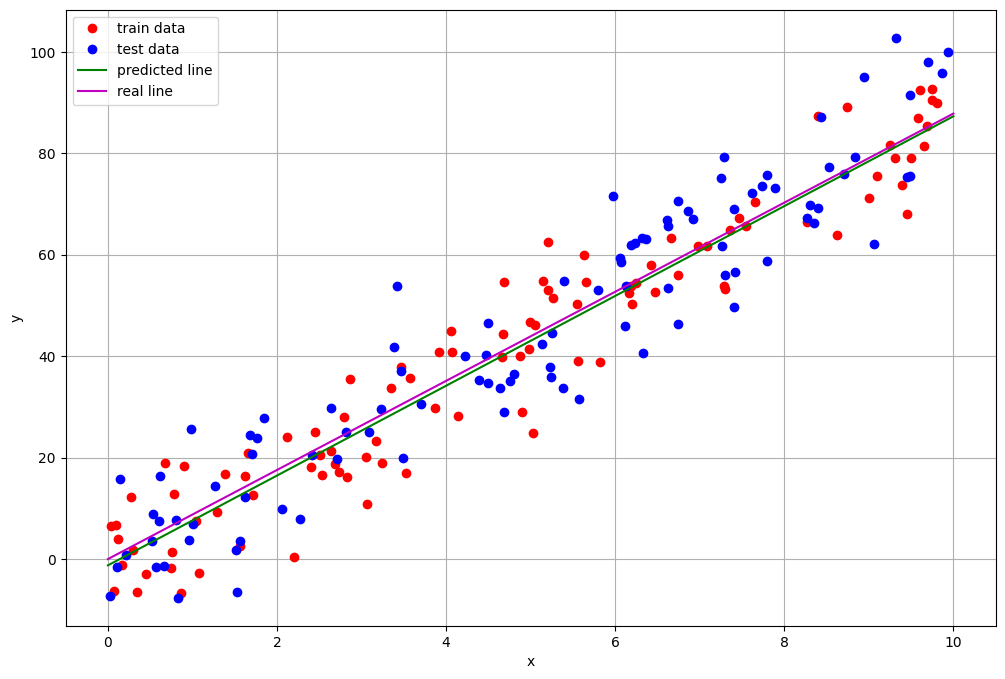

In [183]:
# draw result
x_line = np.linspace(0, 10, 100)
y_line = weights[1] * x_line + weights[0]

plt.figure(figsize=(12, 8))
drawDataset(x_train, y_train, "train data")
drawDataset(x_test, y_test, "test data", 'b')
plt.plot(x_line, y_line, 'g-', label="predicted line")
plt.plot(x_line, linear_func(x_line), 'm-', label="real line")
plt.legend()
plt.show()